# causeLens "Beat The Machine" Challenge

---

```
Student:        Alexandru Rosianu
Username:       ar1g16
```

---

This notebook runs best on [Google Colaboratory](https://colab.research.google.com/).

If a `Beat the machine challenge dataset.csv` file is not found in the current working directory, it will be downloaded from my personal Google Drive.

## Notebook setup

Install dependencies

In [1]:
!pip install gdown numpy pandas matplotlib numba keras tensorflow

Import dependencies:

In [0]:
import os
import requests
import zipfile
import re
import codecs
import tempfile
import unicodedata
import math
from datetime import datetime

In [0]:
import gdown
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from matplotlib import pyplot as plt
from numba import jit

Configure dependencies:

In [0]:
np.random.seed(42)

In [0]:
pd.set_option('display.max_colwidth', 0)              # unlimited max column width
pd.set_option("display.max_columns", 0)               # always display all columns

## Data preparation

Download the dataset:

In [0]:
if not os.path.isfile('Beat the machine challenge dataset.csv'):
  gdown.download('https://drive.google.com/uc?id=10BAo7oiSn5GkfewR-r3yFN7QTXMH0XjP',
                 'Beat the machine challenge dataset.csv', quiet=False)

Load the dataset from disk:

In [0]:
df = pd.read_csv('Beat the machine challenge dataset.csv')

In [8]:
print("dataset samples:", len(df))

dataset samples: 500


In [9]:
df.dtypes

Unnamed: 0    object 
x1            float64
x2            float64
x3            float64
x4            float64
x5            float64
x6            float64
x7            float64
x8            float64
x9            float64
x10           float64
x11           float64
x12           float64
x13           float64
x14           float64
x15           float64
x16           float64
x17           float64
x18           float64
x19           float64
x20           float64
x21           int64  
x22           float64
x23           float64
x24           float64
x25           float64
x26           float64
x27           float64
x28           float64
x29           float64
x30           float64
y             float64
dtype: object

Let's see some rows:

In [10]:
df.head()

,Unnamed: 0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,y
0,2018-06-15T00:00:00.000000Z,-27.155995,0.332523,735.701951,107.513212,1.459349,0.099577,-62.472969,122.606756,0.000297,0.074352,975.335061,101.106560,0.055010,0.120309,-72.300055,107.148625,0.129340,0.546578,253.225491,108.879112,1,-0.195166,0.966355,102.051843,30.555759,24.130086,680.589152,-927.424059,-87.123208,62.666205,1156.681711
1,2018-06-14T00:00:00.000000Z,-17.012365,0.269606,723.576863,107.761407,11.138383,-0.254799,-60.965083,122.834661,0.008695,0.008236,952.063357,101.144274,0.289022,0.074183,-102.182749,107.251029,0.176662,-0.415681,254.127319,108.790883,1,-0.080149,0.965490,102.031867,-12.797338,13.641165,699.645742,-924.946099,-84.658409,63.023348,972.159870
2,2018-06-13T00:00:00.000000Z,-3.306774,-1.054852,738.375336,107.556928,7.168404,-0.158063,-42.867335,122.621138,-0.003350,-0.396932,936.630328,101.327591,0.390140,0.047184,-110.826129,106.945419,0.519777,0.141398,253.639984,108.334500,1,0.036628,0.965188,101.939175,20.709537,27.210881,705.710819,-939.902095,-85.299329,60.244882,1000.999754
3,2018-06-12T00:00:00.000000Z,-20.244923,0.199990,729.565275,107.706857,-8.592282,0.089837,-25.569892,122.127499,-0.000076,-0.588135,931.924493,101.886343,0.261886,0.316889,-139.272069,107.259019,-0.815002,-0.135207,253.111747,108.094492,0,0.001390,0.963559,101.843815,-9.351715,-1.445244,724.573891,-931.245191,-87.296879,57.449428,970.889792
4,2018-06-11T00:00:00.000000Z,11.278201,0.284900,710.838013,107.527512,-12.255875,0.447218,-29.382555,122.137525,-0.002483,0.291105,960.668768,101.964963,0.325531,-0.044946,-139.376583,107.571841,0.751184,-0.282432,251.685643,108.572771,0,-0.818158,0.963392,101.896694,1.270608,-11.391039,733.148718,-922.523210,-86.495199,55.497440,1021.174747


### Parse timestamps

In [11]:
df.rename(columns={'Unnamed: 0': 'timestamp'}, inplace=True)
df['timestamp'] = pd.to_datetime([datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ') for x in df['timestamp']])
df.head()

,timestamp,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,y
0,2018-06-15,-27.155995,0.332523,735.701951,107.513212,1.459349,0.099577,-62.472969,122.606756,0.000297,0.074352,975.335061,101.106560,0.055010,0.120309,-72.300055,107.148625,0.129340,0.546578,253.225491,108.879112,1,-0.195166,0.966355,102.051843,30.555759,24.130086,680.589152,-927.424059,-87.123208,62.666205,1156.681711
1,2018-06-14,-17.012365,0.269606,723.576863,107.761407,11.138383,-0.254799,-60.965083,122.834661,0.008695,0.008236,952.063357,101.144274,0.289022,0.074183,-102.182749,107.251029,0.176662,-0.415681,254.127319,108.790883,1,-0.080149,0.965490,102.031867,-12.797338,13.641165,699.645742,-924.946099,-84.658409,63.023348,972.159870
2,2018-06-13,-3.306774,-1.054852,738.375336,107.556928,7.168404,-0.158063,-42.867335,122.621138,-0.003350,-0.396932,936.630328,101.327591,0.390140,0.047184,-110.826129,106.945419,0.519777,0.141398,253.639984,108.334500,1,0.036628,0.965188,101.939175,20.709537,27.210881,705.710819,-939.902095,-85.299329,60.244882,1000.999754
3,2018-06-12,-20.244923,0.199990,729.565275,107.706857,-8.592282,0.089837,-25.569892,122.127499,-0.000076,-0.588135,931.924493,101.886343,0.261886,0.316889,-139.272069,107.259019,-0.815002,-0.135207,253.111747,108.094492,0,0.001390,0.963559,101.843815,-9.351715,-1.445244,724.573891,-931.245191,-87.296879,57.449428,970.889792
4,2018-06-11,11.278201,0.284900,710.838013,107.527512,-12.255875,0.447218,-29.382555,122.137525,-0.002483,0.291105,960.668768,101.964963,0.325531,-0.044946,-139.376583,107.571841,0.751184,-0.282432,251.685643,108.572771,0,-0.818158,0.963392,101.896694,1.270608,-11.391039,733.148718,-922.523210,-86.495199,55.497440,1021.174747


### Parse bool values

In [12]:
df['x21'] = df['x21'].astype(bool)
df.head()

,timestamp,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,y
0,2018-06-15,-27.155995,0.332523,735.701951,107.513212,1.459349,0.099577,-62.472969,122.606756,0.000297,0.074352,975.335061,101.106560,0.055010,0.120309,-72.300055,107.148625,0.129340,0.546578,253.225491,108.879112,True,-0.195166,0.966355,102.051843,30.555759,24.130086,680.589152,-927.424059,-87.123208,62.666205,1156.681711
1,2018-06-14,-17.012365,0.269606,723.576863,107.761407,11.138383,-0.254799,-60.965083,122.834661,0.008695,0.008236,952.063357,101.144274,0.289022,0.074183,-102.182749,107.251029,0.176662,-0.415681,254.127319,108.790883,True,-0.080149,0.965490,102.031867,-12.797338,13.641165,699.645742,-924.946099,-84.658409,63.023348,972.159870
2,2018-06-13,-3.306774,-1.054852,738.375336,107.556928,7.168404,-0.158063,-42.867335,122.621138,-0.003350,-0.396932,936.630328,101.327591,0.390140,0.047184,-110.826129,106.945419,0.519777,0.141398,253.639984,108.334500,True,0.036628,0.965188,101.939175,20.709537,27.210881,705.710819,-939.902095,-85.299329,60.244882,1000.999754
3,2018-06-12,-20.244923,0.199990,729.565275,107.706857,-8.592282,0.089837,-25.569892,122.127499,-0.000076,-0.588135,931.924493,101.886343,0.261886,0.316889,-139.272069,107.259019,-0.815002,-0.135207,253.111747,108.094492,False,0.001390,0.963559,101.843815,-9.351715,-1.445244,724.573891,-931.245191,-87.296879,57.449428,970.889792
4,2018-06-11,11.278201,0.284900,710.838013,107.527512,-12.255875,0.447218,-29.382555,122.137525,-0.002483,0.291105,960.668768,101.964963,0.325531,-0.044946,-139.376583,107.571841,0.751184,-0.282432,251.685643,108.572771,False,-0.818158,0.963392,101.896694,1.270608,-11.391039,733.148718,-922.523210,-86.495199,55.497440,1021.174747


### Check null values / data shifting

In [13]:
for c in df.columns:
  print(f"any null values for column {c}:", df[c].isnull().values.any())

any null values for column timestamp: False
any null values for column x1: False
any null values for column x2: False
any null values for column x3: False
any null values for column x4: False
any null values for column x5: False
any null values for column x6: False
any null values for column x7: False
any null values for column x8: False
any null values for column x9: False
any null values for column x10: False
any null values for column x11: False
any null values for column x12: False
any null values for column x13: False
any null values for column x14: False
any null values for column x15: False
any null values for column x16: False
any null values for column x17: False
any null values for column x18: False
any null values for column x19: False
any null values for column x20: False
any null values for column x21: False
any null values for column x22: False
any null values for column x23: False
any null values for column x24: False
any null values for column x25: False
any null values

We expect null values for the last *n* rows of `y`.

In [14]:
df[c].isnull().value_counts()

False    475
True     25 
Name: y, dtype: int64

This means the entire dataset is already shifted by *n*. We'll be predicting *n* values into the future.

## Data exploration

### Dataset size

In [15]:
print("dataset samples:", len(df))

dataset samples: 500


### Feature names and types

In [16]:
df.dtypes

timestamp    datetime64[ns]
x1           float64       
x2           float64       
x3           float64       
x4           float64       
x5           float64       
x6           float64       
x7           float64       
x8           float64       
x9           float64       
x10          float64       
x11          float64       
x12          float64       
x13          float64       
x14          float64       
x15          float64       
x16          float64       
x17          float64       
x18          float64       
x19          float64       
x20          float64       
x21          bool          
x22          float64       
x23          float64       
x24          float64       
x25          float64       
x26          float64       
x27          float64       
x28          float64       
x29          float64       
x30          float64       
y            float64       
dtype: object

### Feature: timestamp

In [17]:
print("earliest sample in dataset:", np.min(df['timestamp']))
print("newest sample in dataset:", np.max(df['timestamp']))

earliest sample in dataset: 2017-02-01 00:00:00
newest sample in dataset: 2018-06-15 00:00:00


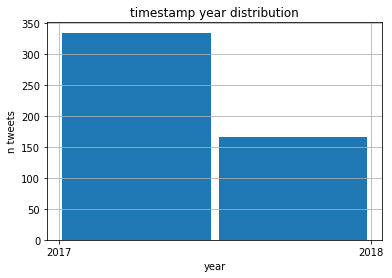

In [18]:
x = df['timestamp'].dt.year.hist(bins=len(np.unique(df['timestamp'].dt.year.values)), rwidth=0.95)
plt.title('timestamp year distribution')
plt.xticks(np.unique(df['timestamp'].dt.year.values))
plt.xlabel('year')
plt.ylabel('n tweets')
plt.show()

### Statistics

In [19]:
df.describe()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x22,x23,x24,x25,x26,x27,x28,x29,x30,y
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,475.000000
mean,0.636760,0.020915,163.864174,104.282519,-1.360987,0.027161,95.192594,110.806960,0.004561,0.026340,397.128231,103.858585,0.198941,0.015609,-9.128091,105.113406,0.365377,0.031999,126.847040,102.429320,0.013421,0.492225,100.431536,1.232562,-0.135195,534.196961,-365.805170,-59.105021,33.499174,385.169057
std,19.625065,0.500444,258.171494,3.812484,14.746983,0.224823,96.780256,6.287921,0.005371,0.497810,258.565458,2.490610,0.164789,0.135783,209.547587,2.209549,0.434803,0.406289,72.791316,2.775098,0.377715,0.282541,0.580523,20.092387,20.027858,254.615314,361.072892,33.120873,30.832177,267.983665
min,-64.325347,-1.502870,-190.290988,97.980418,-43.243798,-0.581438,-87.148440,99.915422,-0.015954,-1.789606,-24.246239,97.665087,-0.348410,-0.424430,-366.784231,99.591529,-0.849214,-1.229043,0.003026,96.483427,-1.023990,0.011156,99.241736,-59.126971,-59.145102,-44.187723,-1073.420233,-97.356914,-16.498633,-93.633119
25%,-13.506148,-0.298953,-0.770036,99.977909,-11.006332,-0.130007,14.858424,105.527776,0.001073,-0.304740,210.171109,102.279560,0.092449,-0.079353,-172.922969,103.560978,0.081055,-0.258374,67.057316,100.216065,-0.243375,0.256551,100.045300,-12.302206,-13.658353,356.008483,-697.802972,-85.058646,5.875320,198.516602
50%,0.755943,0.021017,49.570954,106.437254,-0.936253,0.032883,80.115770,109.390560,0.004493,0.009079,316.343097,103.793933,0.199173,0.012659,-63.270806,105.504945,0.394797,0.049099,124.076124,102.286299,0.023484,0.482818,100.402747,0.392399,-0.570282,450.890093,-214.194892,-72.595242,23.247975,299.448733
75%,13.235665,0.349607,368.065948,107.493754,8.311244,0.174029,164.202228,115.379594,0.008182,0.365607,598.530400,105.318941,0.305967,0.116775,173.177916,106.930332,0.648395,0.302926,191.711206,104.461930,0.259742,0.738979,100.771365,15.700343,14.320418,776.758283,-93.123841,-26.476740,66.396549,548.535826
max,77.554630,1.464767,752.771409,109.644463,51.435366,0.639040,298.409410,123.753326,0.023227,1.397665,987.831850,109.616757,0.712267,0.440834,468.893360,108.341206,1.610703,1.108395,254.127319,109.146246,1.872818,0.966355,102.051843,59.498737,68.737467,928.204958,164.544009,13.174503,82.853148,1156.681711


### Time deltas

In [20]:
timestamp_deltas = (df['timestamp'].shift() - df['timestamp']).iloc[1:]
print(f"all timestamps have the same delta of 1 day: " +
      f"{len(timestamp_deltas) == len(timestamp_deltas[timestamp_deltas == '1 day'])}")

all timestamps have the same delta of 1 day: True


### Plots against timestamp

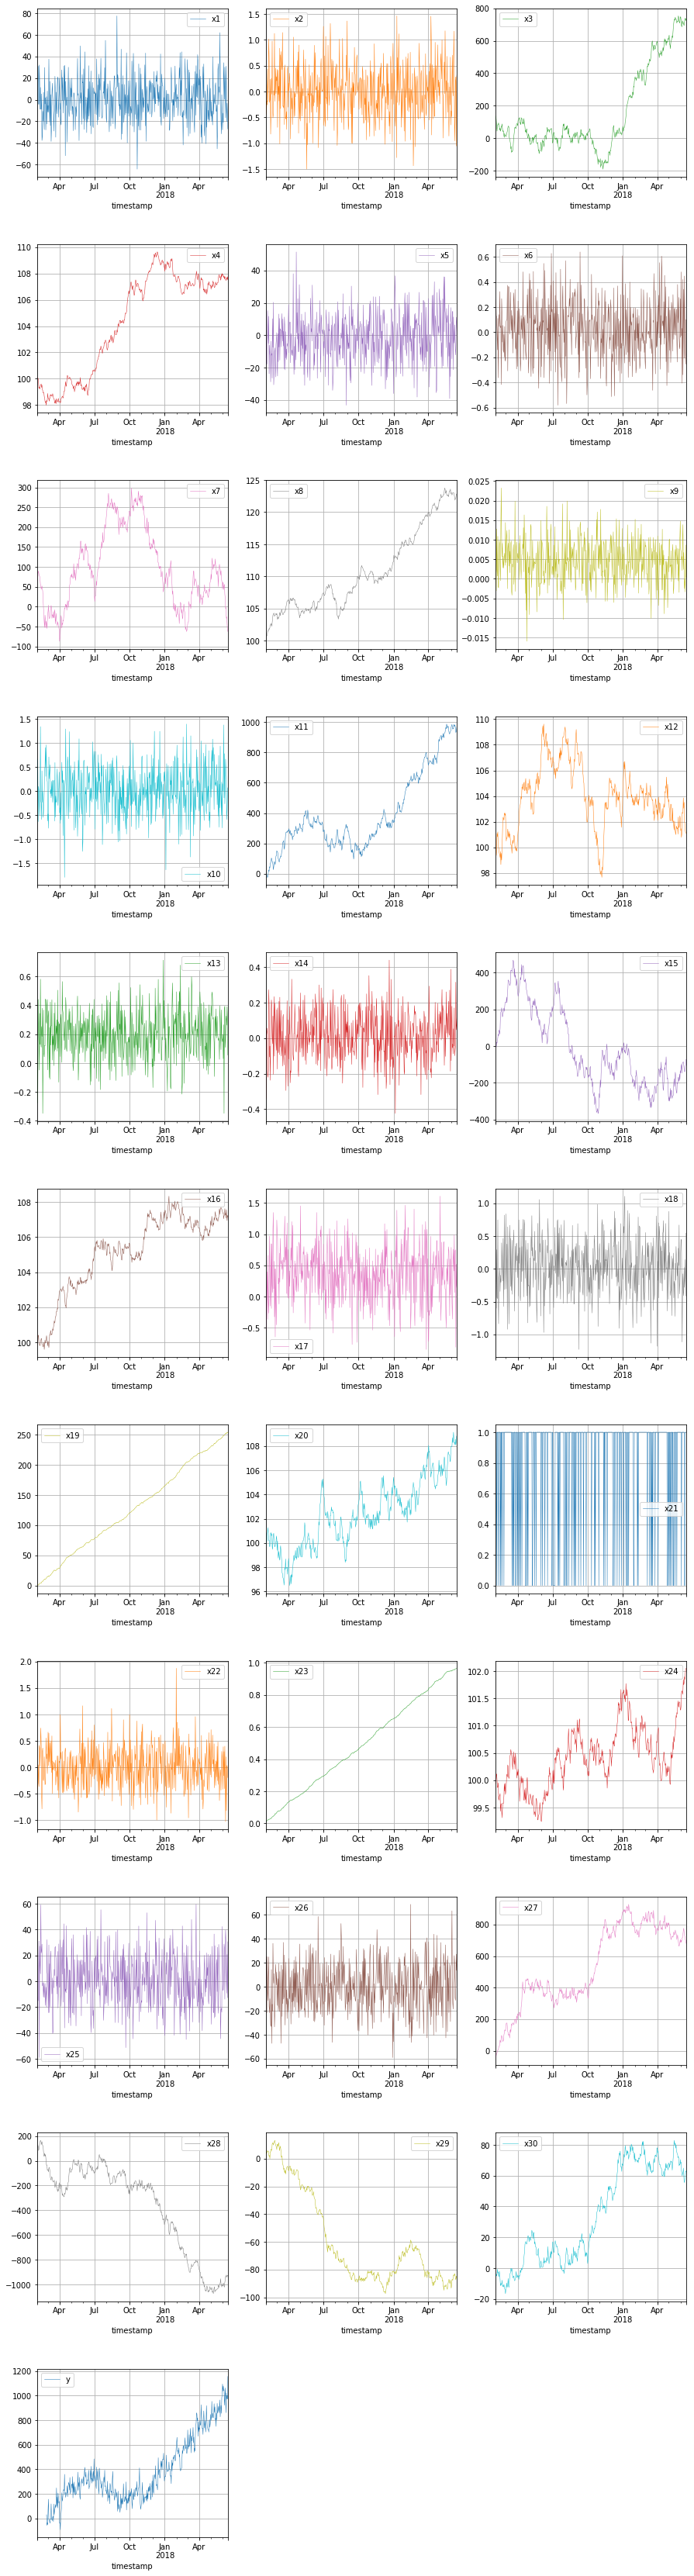

In [21]:
df_copy = df.copy()
df_copy['x21'] = df_copy['x21'].astype(int)
ax = df_copy.plot(x='timestamp', subplots=True, grid=True, layout=(11,3), sharex=False, sharey=False,
                  linewidth=0.5, figsize=(15,60))
plt.subplots_adjust(hspace=0.4)
plt.show()

## Prediction attempt 1: Keras, Tensorflow, RNN, all samples, all features

In [0]:
shift_steps = 25

In [23]:
x_data = df[['x'+str(i) for i in range(1, 31)]].astype(float).values[shift_steps:]
print(f"{x_data.dtype} {x_data.shape}")

float64 (475, 30)


In [24]:
y_data = df['y'].values[:-shift_steps].reshape(-1, 1)
print(f"{y_data.dtype} {y_data.shape}")

float64 (475, 1)


In [0]:
x_scaler = MinMaxScaler()
x_data_scaled = x_scaler.fit_transform(x_data)

In [0]:
y_scaler = MinMaxScaler()
y_data_scaled = y_scaler.fit_transform(y_data)

In [0]:
def batch_generator(batch_size, sequence_length):
  while True:
    # Allocate a new array for the batch of input-signals.
    x_shape = (batch_size, sequence_length, x_data.shape[1])
    x_batch = np.zeros(shape=x_shape, dtype=np.float64)

    # Allocate a new array for the batch of output-signals.
    y_shape = (batch_size, sequence_length, y_data.shape[1])
    y_batch = np.zeros(shape=y_shape, dtype=np.float64)

    # Fill the batch with random sequences of data.
    for i in range(batch_size):
      # Get a random start-index.
      # This points somewhere into the training-data.
      idx = np.random.randint(len(x_data) - sequence_length)

      # Copy the sequences of data starting at this index.
      x_batch[i] = x_data_scaled[idx:idx+sequence_length]
      y_batch[i] = y_data_scaled[idx:idx+sequence_length]

    yield (x_batch, y_batch)

In [0]:
batch_size = 64

In [0]:
sequence_length = 50

In [0]:
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [0]:
x_batch, y_batch = next(generator)

In [32]:
print(x_batch.shape)
print(y_batch.shape)

(64, 50, 30)
(64, 50, 1)


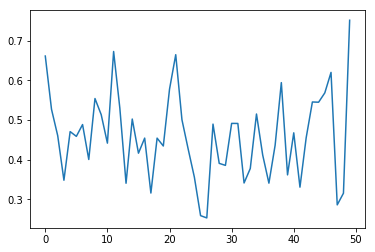

In [33]:
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 30 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)

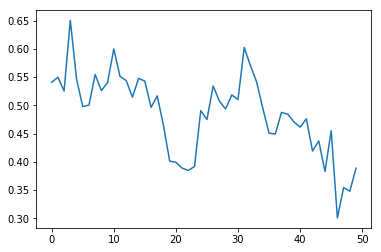

In [34]:
seq = y_batch[batch, :, signal]
plt.plot(seq)

In [0]:
# https://www.kaggle.com/c/web-traffic-time-series-forecasting/discussion/37232
@jit
def smape_fast(y_true, y_pred):
  out = 0
  for i in range(y_true.shape[0]):
    a = y_true[i]
    b = y_pred[i]
    c = a+b
    if c == 0:
      continue
    out += math.fabs(a - b) / c
  out *= (200.0 / y_true.shape[0])
  return out

In [0]:
def loss_smape(y_true, y_pred):
  # The shape of both input tensors are:
  # [batch_size, sequence_length, num_y_signals].

  y_true = tf.transpose(y_true, [0, 2, 1])
  y_pred = tf.transpose(y_pred, [0, 2, 1])
  
  # [batch_size, num_y_signals, sequence_length].
  # [64, 1, 50]
  
  s = tf.abs(y_true - y_pred) / (y_true + y_pred)
  f = 200.0 / tf.cast(tf.shape(y_true)[2], tf.float32)
  a = tf.reduce_sum(s, axis=2) * f
  return tf.reduce_mean(a)

In [37]:
model = Sequential()
model.add(GRU(units=32, return_sequences=True, input_shape=(None, x_data.shape[1])))
model.add(Dense(y_data.shape[1], activation='sigmoid'))
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_smape, optimizer=optimizer)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 32)          6048      
_________________________________________________________________
dense (Dense)                (None, None, 1)           33        
Total params: 6,081
Trainable params: 6,081
Non-trainable params: 0
_________________________________________________________________


In [0]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='loss',
                                        patience=5, verbose=1)

# callback_tensorboard = TensorBoard(log_dir='./23_logs/',
#                                    histogram_freq=0,
#                                    write_graph=False)

callback_reduce_lr = ReduceLROnPlateau(monitor='loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
#              callback_tensorboard,
             callback_reduce_lr]

In [39]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
#                     validation_data=validation_data,
                    callbacks=callbacks)

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
 99/100 [============================>.] - ETA: 0s - loss: 20.0503
Epoch 00001: loss improved from inf to 20.00818, saving model to 23_checkpoint.keras
100/100 [==============================] - 9s 91ms/step - loss: 20.0082
Epoch 2/20
 99/100 [============================>.] - ETA: 0s - loss: 14.9670
Epoch 00002: loss improved from 20.00818 to 14.94259, saving model to 23_checkpoint.keras
100/100 [==============================] - 8s 81ms/step - loss: 14.9426
Epoch 3/20
 99/100 [============================>.] - ETA: 0s - loss: 13.9988
Epoch 00003: loss improved from 14.94259 to 13.99124, saving model to 23_checkpoint.keras
100/100 [==============================] - 8s 81ms/step - loss: 13.9912
Epoch 4/20
 99/100 [============================>.] - ETA: 0s - loss: 13.4044
Epoch 00004: loss improved from 13.99124 to 13.39850, saving model to 23_checkpoint.keras
100/100 [==============================] - 8s 82ms/step - loss: 13.39

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Prediction attempt 2: Keras, Tensorflow, RNN, train/test split, all features

In [0]:
shift_steps = 25

### Numpy arrays

In [42]:
x_data = df[['x'+str(i) for i in range(1, 31)]].astype(float).values[shift_steps:]
print(f"{x_data.dtype} {x_data.shape}")

float64 (475, 30)


In [43]:
y_data = df['y'].values[:-shift_steps].reshape(-1, 1)
print(f"{y_data.dtype} {y_data.shape}")

float64 (475, 1)


### Train/test split

In [0]:
train_split = 0.9

In [45]:
num_data = len(x_data)
num_data

475

In [46]:
num_train = int(train_split * num_data)
num_train

427

In [47]:
num_test = num_data - num_train
num_test

48

In [48]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

475

In [49]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

475

In [50]:
num_x_signals = x_data.shape[1]
num_x_signals

30

In [51]:
num_y_signals = y_data.shape[1]
num_y_signals

1

### Scaling

In [0]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

In [0]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

### Validation set

In [0]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

### Batch generator

In [0]:
def batch_generator(batch_size, sequence_length):
  while True:
    # Allocate a new array for the batch of input-signals.
    x_shape = (batch_size, sequence_length, num_x_signals)
    x_batch = np.zeros(shape=x_shape, dtype=np.float64)

    # Allocate a new array for the batch of output-signals.
    y_shape = (batch_size, sequence_length, num_y_signals)
    y_batch = np.zeros(shape=y_shape, dtype=np.float64)

    # Fill the batch with random sequences of data.
    for i in range(batch_size):
      # Get a random start-index.
      # This points somewhere into the training-data.
      idx = np.random.randint(num_train - sequence_length)

      # Copy the sequences of data starting at this index.
      x_batch[i] = x_train_scaled[idx:idx+sequence_length]
      y_batch[i] = y_train_scaled[idx:idx+sequence_length]

    yield (x_batch, y_batch)

In [0]:
batch_size = 32
sequence_length = 100
start_lr = 1e-3
generator = batch_generator(batch_size=batch_size, sequence_length=sequence_length)

In [141]:
x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(32, 100, 30)
(32, 100, 1)


### Loss function

In [0]:
def loss_smape(y_true, y_pred):
  # The shape of both input tensors are:
  # [batch_size, sequence_length, num_y_signals].

  y_true = tf.transpose(y_true, [0, 2, 1])
  y_pred = tf.transpose(y_pred, [0, 2, 1])
  
  # [batch_size, num_y_signals, sequence_length].
  # [64, 1, 50]
  
  s = tf.abs(y_true - y_pred) / (y_true + y_pred)
  f = 200.0 / tf.cast(tf.shape(y_true)[2], tf.float32)
  a = tf.reduce_sum(s, axis=2) * f
  return tf.reduce_mean(a)

### Model

In [154]:
model = Sequential()
model.add(GRU(units=64, return_sequences=True, input_shape=(None, num_x_signals)))
# model.add(Dense(128, activation='relu'))
# model.add(Dense(32, activation='relu'))
model.add(Dense(num_y_signals, activation='sigmoid'))
optimizer = RMSprop(lr=start_lr)
model.compile(loss=loss_smape, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_12 (GRU)                 (None, None, 64)          18240     
_________________________________________________________________
dense_14 (Dense)             (None, None, 1)           65        
Total params: 18,305
Trainable params: 18,305
Non-trainable params: 0
_________________________________________________________________


In [0]:
path_checkpoint = '23_checkpoint.keras'

callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1)

callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-3,
                                       patience=0,
                                       verbose=1)

callbacks = [
#     callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr
            ]

In [156]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=10,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
1/1 [==============================] - 0s 348ms/sample - loss: 231.8844

Epoch 00001: val_loss improved from inf to 231.88441, saving model to 23_checkpoint.keras
10/10 [==============================] - 5s 473ms/step - loss: 59.0954 - val_loss: 231.8844
Epoch 2/20
1/1 [==============================] - 0s 21ms/sample - loss: 244.9554

Epoch 00002: val_loss did not improve from 231.88441

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.001.
10/10 [==============================] - 3s 254ms/step - loss: 37.4195 - val_loss: 244.9554
Epoch 3/20
1/1 [==============================] - 0s 22ms/sample - loss: -79.0854

Epoch 00003: val_loss improved from 231.88441 to -79.08540, saving model to 23_checkpoint.keras
10/10 [==============================] - 2s 169ms/step - loss: 31.0784 - val_loss: -79.0854
Epoch 4/20
1/1 [==============================] - 0s 18ms/sample - loss: 421.1284

Epoch 00004: val_loss did not improve from -79.08540

Epoch 00004: ReduceLROnPlateau re

In [0]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [98]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
result

1/1 [==============================] - 0s 25ms/sample - loss: -176.1479


-176.1478729248047

### Plot test predictions

In [0]:
target_names = ['y']

def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
#         p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

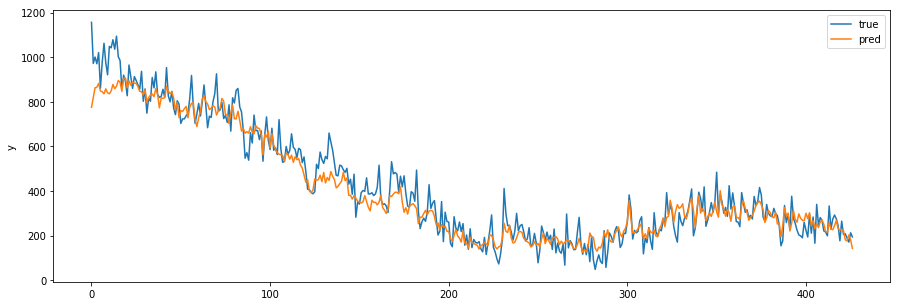

In [100]:
plot_comparison(start_idx=0, length=1000, train=True)

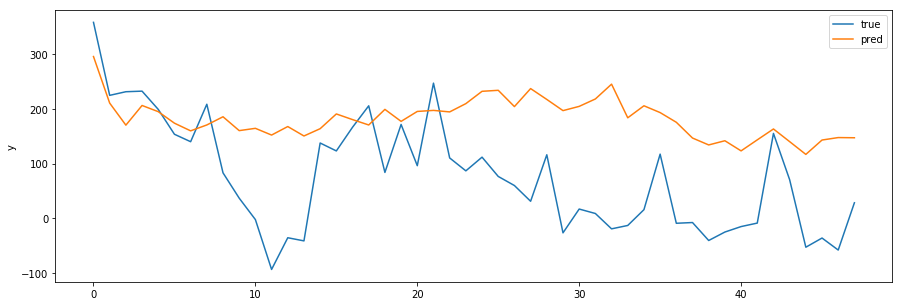

In [101]:
plot_comparison(start_idx=0, length=1000, train=False)

### Final predictions

In [161]:
final_preds = model.predict(np.expand_dims(x_test_scaled[:25], axis=0))
final_preds = np.squeeze(final_preds)
final_preds = y_scaler.inverse_transform(final_preds.reshape(1, -1))

final_preds_df = pd.Series(np.squeeze(final_preds))
final_preds_df.to_csv('approach2.csv')
final_preds_df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


0     428.442200
1     285.792419
2     199.482056
3     213.255203
4     207.138947
5     209.589661
6     196.428635
7     185.805084
8     207.460251
9     194.817551
10    196.528244
11    174.428879
12    190.786591
13    185.161560
14    191.090836
15    196.116623
16    215.471344
17    186.182205
18    209.048264
19    207.422699
20    207.795990
21    205.929138
22    200.606628
23    230.964203
24    238.911377
dtype: float32